# Road User Classification
#### by Kuanchieh Peng

## Problem Statement
> Build a best feasible model that classifies road users. The top priorities in order are: maximizing classification accuracy on unseen data, minimizing time taken for classifying unseen data, then minimizing time taken for training the classifier.

## Imports

In [48]:
import pandas as pd
import numpy as np

# for min-max scaling
from mlxtend.preprocessing import minmax_scaling

# for preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# for plotting
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# for modeling
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.svm import LinearSVC

In [60]:
df = pd.read_csv('vrudata.csv')
original_df = df.copy()

## Pipeline

In [50]:
class bold:
    start = '\033[1m'
    end   = '\033[0m'

def info(df):
    # Prints typically useful statistical information about given dataframe.
    
    print("This dataframe consists of ", df.shape[1], " columns and", df.shape[0], " rows.")
    print("This dataframe consists of ", df.isnull().sum().sum(), " null entires.")
    print("This dataframe consists of ", df[df.duplicated()].shape[0], " duplicate rows.")
    print(df[df['target'] == 1].shape[0], " rows belong to class target = 1.")
    print(df[df['target'] == 0].shape[0], " rows belong to class target = 0.")
    print("")
    print(bold.start, "Notable statistics of numeric features in this dataset:", bold.end)
    print("")
    print(df.describe())
    print("")
    print(bold.start, "Object type of features in this dataset:", bold.end)
    print("")
    df.info()
    
def dist_box(x, title = ''):
    fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (14.4, 7.2))
    for ax in axes:
        sns.kdeplot(x, shade = False, ax = ax)
        kdeline = ax.lines[0]
        xs = kdeline.get_xdata()
        ys = kdeline.get_ydata()
        if ax == axes[0]:
            middle = x.mean()
            sdev = x.std()
            left = middle - sdev
            right = middle + sdev
            ax.set_title('Mean and SD')
        else:
            left, middle, right = np.percentile(x, [25, 50, 75])
            ax.set_title('Median and Quartiles')
        ax.vlines(middle, 0, np.interp(middle, xs, ys), ls = ':')
        ax.fill_between(xs, 0, ys, alpha = 0.2)
        ax.fill_between(xs, 0, ys, where = (left <= xs) & (xs <= right), interpolate = True, alpha = 0.2)
    fig.suptitle(title, fontsize = 16)
    plt.show()
    
def three_d_scatter(df, target = 'target'):
    fig = plt.figure(figsize = (14.4, 10.8))
    ax = fig.add_subplot(111, projection = '3d')
    df_target1 = df[df[target] == 1]
    df_target0 = df[df[target] == 0]
    legend_properties = {}

    ax.scatter(df_target1['acc_x'], df_target1['acc_y'], df_target1['acc_z'], marker = 'x', label = 'Cars')
    ax.scatter(df_target0['acc_x'], df_target0['acc_y'], df_target0['acc_z'], marker = 'o', label = 'Non Cars')
    plt.legend(loc = 'best', prop = legend_properties)
    plt.show()

## EDA & Visualization

In [51]:
df.head(3)

,acc_x,acc_y,acc_z,target
0,-0.113725,0.083797,9.654618,not car
1,-0.098162,0.087388,9.630676,not car
2,-0.099359,0.094571,9.645041,not car


#### Cleaning
- Use info() from our pipeline to check whether data needs cleaning.

In [52]:
info(df)

This dataframe consists of  4  columns and 120000  rows.
This dataframe consists of  0  null entires.
This dataframe consists of  8186  duplicate rows.
0  rows belong to class target = 1.
0  rows belong to class target = 0.

 Notable statistics of numeric features in this dataset: 

               acc_x          acc_y          acc_z
count  120000.000000  120000.000000  120000.000000
mean       -0.354549       5.367115       6.729311
std         1.931744       3.420114       2.588606
min       -12.509735     -19.051361     -19.093689
25%        -1.116619       1.902695       4.829160
50%        -0.529119       6.922834       6.459327
75%        -0.092177       8.182184       9.212952
max        36.782090      13.737244      60.973206

 Object type of features in this dataset: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   acc_x   120000 non-nu

- There are no missing values in the dataframe.
- The three features acc_x, acc_y, acc_z are in desired data type (float, instead of string like object).
- Notable statistic: The data has perfectly balanced classes.

#### One-Hot Encoding
- Our target variable is categorical, therefore I shall encode it. Since there is no ordinality within our target variable, perform one-hot encoding instead of integer encoding.
- Use pd.get_dummies to encode.

In [53]:
df['target'] = pd.get_dummies(df.target, drop_first = False)
df.head(3)

,acc_x,acc_y,acc_z,target
0,-0.113725,0.083797,9.654618,0
1,-0.098162,0.087388,9.630676,0
2,-0.099359,0.094571,9.645041,0


#### Transformation
- Use df.skew() to determine whether our features are skewed, meaning whether transformation is neeeded.
- Plot distplot-boxplot combined plots to for better interpretability.

In [54]:
df.skew(axis = 0)

acc_x     5.031114
acc_y    -0.793934
acc_z    -0.329718
target    0.000000
dtype: float64

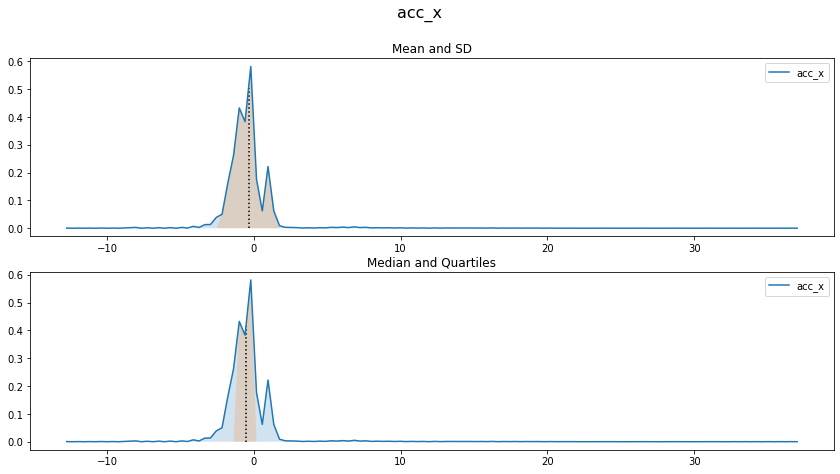

In [55]:
dist_box(df['acc_x'], 'acc_x')

- acc_x is right skewed. Perform log transformation on the data.

C:\Users\kuanc\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


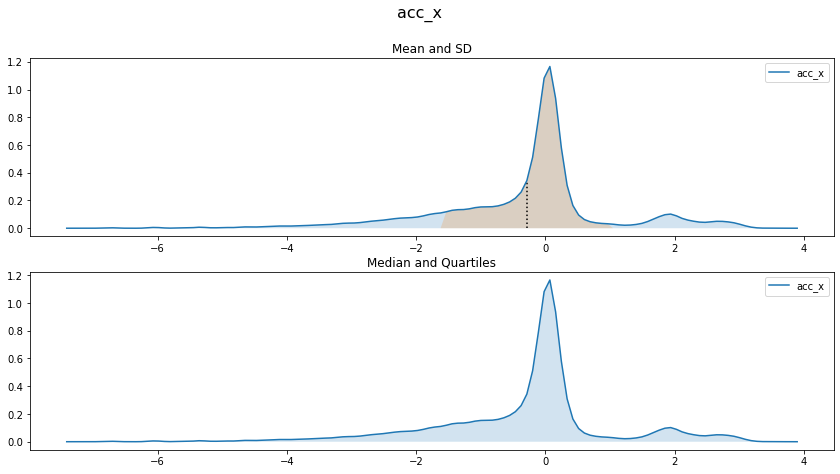

In [62]:
df['acc_x'] = np.log(original_df['acc_x'])
dist_box(df['acc_x'], 'acc_x')

In [47]:
df.skew(axis = 0)

acc_x    -0.196280
acc_y    -0.793934
acc_z    -0.329718
target    0.000000
dtype: float64

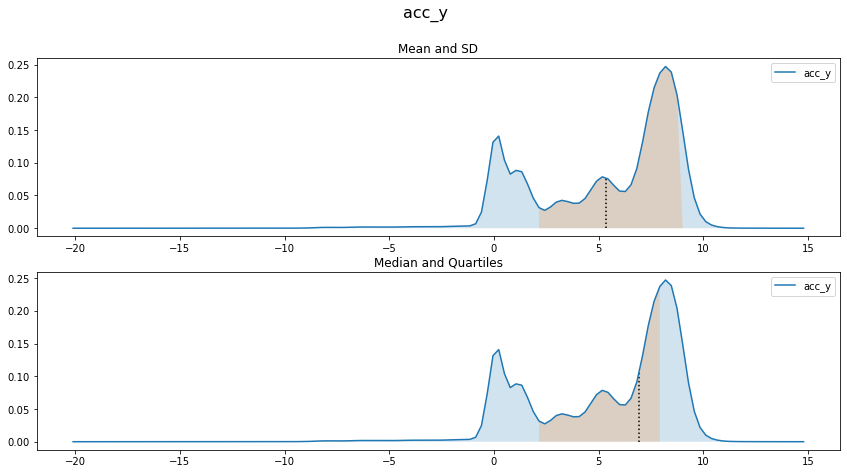

In [36]:
dist_box(df['acc_y'], 'acc_y')

- accy is only slgihtly (skew coefficient < 1) but obviously left skewed (apparently mean < median < mode).

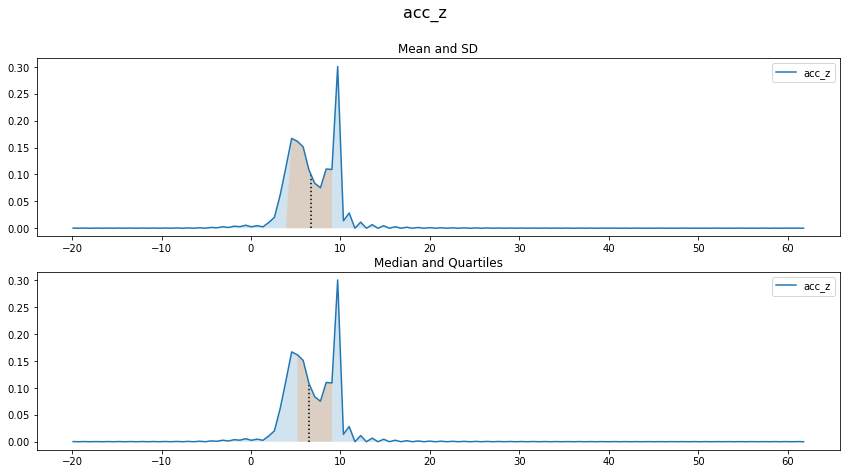

In [35]:
dist_box(df['acc_z'], 'acc_z')

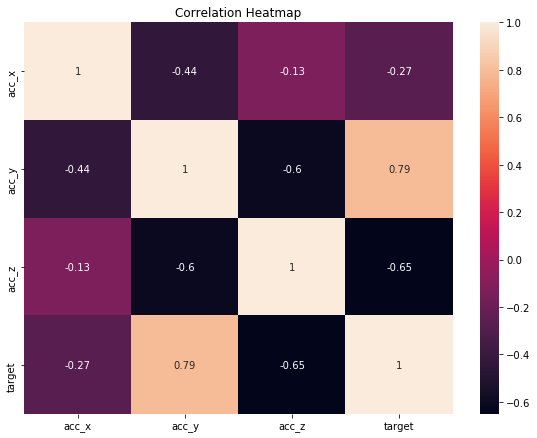

In [9]:
plt.figure(figsize = (9.6, 7.2))
sns.heatmap(df.corr(), xticklabels = df.corr().columns, yticklabels = df.corr().columns, annot = True)
plt.title("Correlation Heatmap")
plt.show()

There is little to none multicollinearity in our data.

acc_y highly correlated to target variables. possible reason: car travelling at higher speeds prior to hitting brakes compared to pedestrains or bikers.

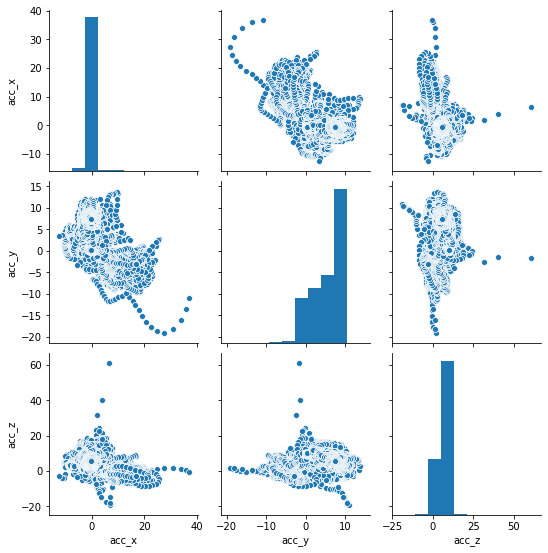

In [10]:
sns.pairplot(df.drop(['target'], axis = 1))

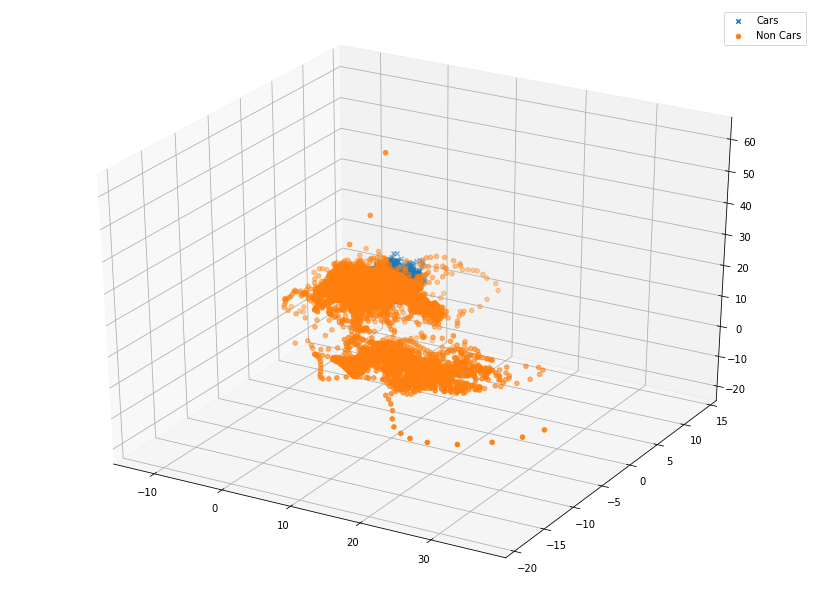

In [14]:
three_d_scatter(df)

- According to the 3-D graph above, data of the two classes might be linearly separable.
- In the following block, to determine whether the data is linearly separable, I trained a hard margin SVC with the data. If the training is able to find a margin for the hard margin SVM, the data is linearly separable; vice versa.
- I used a linear SVC with the regularization parameter C set to infinity for the hard margin SVC desired. For large values of C, the optimization will choose a smaller-margin hyperplane if that hyperplane does a better job of getting all the training points classified correctly. When C is set a infininty, we get a hard margin SVM.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df[{'acc_x', 'acc_y', 'acc_z'}],
                                                   df['target'],
                                                   test_size = 0.2,
                                                   random_state = 42)
#X_validation, X_test, y_validation, y_test = train_test_split(X_test,
#                                                   y_test,
#                                                   test_size = 0.2,
#                                                   random_state = 42)

clf = make_pipeline(StandardScaler(), LinearSVC(C = float('inf'), max_iter = 10000))
clf.fit(X_train, y_train)
clf.score(X_train, y_train)

C:\Users\kuanc\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.8903229166666666

In [16]:
clf.score(X_test, y_test)

0.8902916666666667

- The hard margin SVC found a margin and surprisingly did not overfit. As a result, the data is linearly separable.

## Summary Before Modeling

The entire dataset consists of **3 continuous feature columns, 1 categorical target column, and 120,000 rows**. The feature columns are in float type, and the target column is one hot encoded into integers ranging from 0 to 1, inclusive.

Feature acc_y and the target variable has considerably high correlation .79. The distribution of the three features are either skewed left, right, and right in the order acc_x, acc_y, and acc_z. There are no outliers in any of the three.

**Data of the two classes are linearly separable.**

Since I'm trying to predict categories and have labeled data, consider training classifiers. Since we have a large amount of data and care about limiting training time, consider using stochastic gradient descent to optimize our classifier.

## Classification